In [ ]:
!pip install arviz
!pip install pymc3==3.9

In [72]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#import arviz as az

# Exercise 1

In [3]:
df = pd.read_csv("exam_question1.csv")
x01 = df['x1']
x02 = df['x2']

# target
y0 = df['y']
df.sample(5)

,x1,x2,y
34,-0.59,-1.58,1.0
20,1.24,-0.98,0.0
28,-0.77,-0.19,1.0
10,0.87,-0.47,1.0
18,0.17,-0.03,0.0


<Figure size 432x288 with 0 Axes>

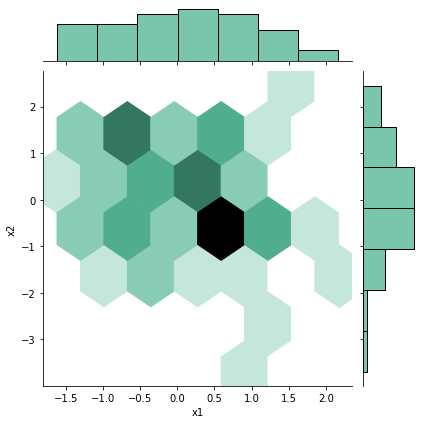

In [70]:
plt.figure()
seaborn.jointplot(df['x1'],df['x2'], df['y'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

In [77]:
# 1
# 
with pm.Model() as logistic_model:
  alpha = pm.Normal('alpha', 0.0, sd=30)
  beta1  = pm.Normal('beta1',  0.0, sd=30)
  beta2  = pm.Normal('beta2',  0.0, sd=30)
    # complete the model
  sig = pm.Uniform('sig',.0001,30)          #ADDED

  mu = pm.Deterministic('mu', pm.math.invlogit(alpha + (pm.math.dot(X, beta1)+beta2))
  like = pm.Normal('Like', mu, sig, observed = y0)  #ADDED

with logistic_model:
    approx = pm.fit(80000)#ADVI method

posterior = approx.sample(10000)

SyntaxError: ignored

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(0.01 * posterior['beta1'] + posterior['alpha'], bins=50)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(0.008 * posterior['beta2'] + posterior['alpha'], bins=50)
plt.show()

# Exercise 2

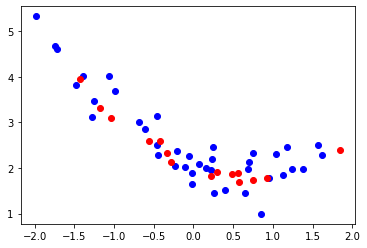

In [4]:
df2 =pd.read_csv("exercise2_data_sensor1.csv")
x1 =df2['temperature']
y1 =df2['pressure']

df3=pd.read_csv("exercise2_data_sensor2.csv")
x2=df3['temperature']
y2=df3['pressure']

plt.scatter(x1, y1, color='b',label="sensor 1")
plt.scatter(x2, y2, color='r',label="sensor 2")

In [29]:
import seaborn

<Figure size 432x288 with 0 Axes>

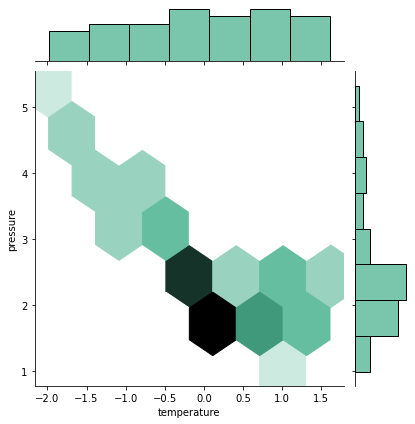

In [30]:
plt.figure()
seaborn.jointplot(df2['temperature'], df2['pressure'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

<Figure size 432x288 with 0 Axes>

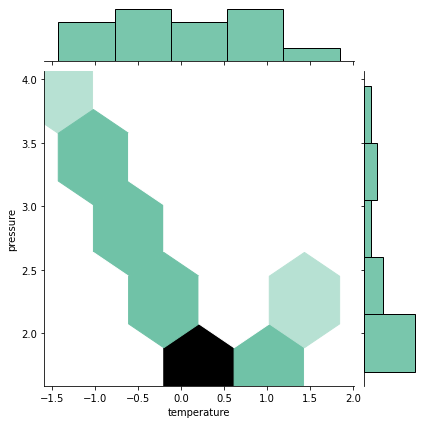

In [31]:
plt.figure()
seaborn.jointplot(df3['temperature'], df3['pressure'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

In [10]:
deg = 4
Xscalar0 = x1#.reshape(-1,1)
for i in range(1, deg+1):
    Xscalar0 = np.hstack([Xscalar0, x1#.reshape(-1,1)
    **i]) #polynomial features

Xscalar1 = x2#.reshape(-1,1)
for i in range(1, deg+1):
    Xscalar1 = np.hstack([Xscalar1, x2#.reshape(-1,1)
    **i]) #polynomial features

# x = 1.8

with pm.Model() as poly_reg:        
    alpha  = pm.Normal('alpha', 0.0, sd=30)
    beta1   = pm.Normal('beta1', 0.0, sd=30)
    beta2   = pm.Normal('beta2', 0.0, sd=30)
    sigma1 = pm.Uniform('sigma1', 0.0001, 30)
    sigma2 = pm.Uniform('sigma2', 0.0001, 30)
    
    #Scalar data x1 temperature
    mu0 = alpha + pm.math.dot(Xscalar0, beta1)
    like0 = pm.Normal('Like0', mu0, sigma1, observed=y1)

    #Scalar data x2 temperature
    mu1 = alpha + pm.math.dot(Xscalar1, beta2)
    like1 = pm.Normal('Like0', mu1, sigma2, observed=y2)

with poly_reg:
    approx = pm.fit(80000)#ADVI
    
posterior = approx.sample(10000)

pm.plot_posterior(posterior, color='LightSeaGreen', kind='hist', bins=50)

plt.figure(figsize=(6,6))
plt.hist(1.8 * posterior['beta'] + posterior['alpha'], bins=50)
plt.show()

In [ ]:
pm.plot_posterior(posterior, color='LightSeaGreen', kind='hist', bins=50)

In [ ]:
#ADDED
#
xx = np.linspace(np.min(np.hstack([x1,x2])),np.max(np.hstack([x1,x2])))
for i in range(100):
  plt.plot(xx, xx * posterior['beta'][i]+posterior['alpha'][i], c='gray', alpha=.1)
  plt.plot(xx, xx * posterior['beta'].mean()+posterior['alpha'].mean(), c='orange')

plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.xlabel("temperature", fontsize=11)
plt.ylabel("pressure", fontsize=11)
plt.show()

# Exercise 3

In [37]:
with pm.Model() as my_model:        
    alpha  = pm.Normal('alpha', 0, 30)
    beta  = pm.Normal('beta', 0, 30)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=alpha + beta*x1
    like = pm.Normal('likelihood', pm.math.invlogit(mu), sigma, observed=y1)

In [38]:
with pm.Model() as my_model:        
    alpha  = pm.Normal('alpha', 0, 30)
    beta  = pm.Normal('beta', 0, 30)
    sigma  = pm.Uniform('sigma', 0.001, 15)
    mu=alpha + beta*x1
    like = pm.Normal('likelihood', mu, sigma, observed=y1)

In [ ]:
with pm.Model() as my_model:        
    alpha  = pm.Unif('alpha', 2,5)
    gamma  = pm.Normal('gamma', -3.0, sd=3)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=gamma*x**3/(alpha+x)
    like = pm.Normal('likelihood', mu, sigma, observed=y)

In [ ]:
with pm.Model() as my_model:        
    alpha  = pm.Unif('alpha', 2,5)
    gamma  = pm.Normal('gamma', -3.0, sd=3)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=alpha+gamma*x
    like = pm.Normal('likelihood', mu, sigma, observed=y)

# Exercise 4

In [48]:
# 𝑛=640 tosses,  340 Heads and 300 Tails

h = 340/640
t = 300/640
y = h+t

with pm.Model() as coin_model:
    # prior
    theta = pm.Uniform("theta", 0,1)
    
    #like
    like = pm.Bernoulli("like", theta, observed = h)
    
with coin_model:    
    posterior = pm.sample(15000, tune=3000, chains=1)

len(np.where(posterior['theta']>=0.5)[0])/len(posterior['theta'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 18000/18000 [00:08<00:00, 2209.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


0.2472

# Exercise 5

In [ ]:
for i in range(1,8):
  

# Exercise 6

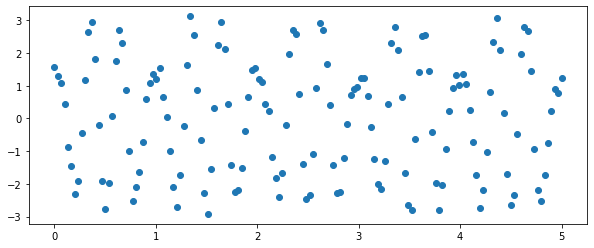

In [53]:
df6 = pd.read_csv("exam_question6.csv")
x6 = df6['x']
y6 = df6['y']
plt.figure(figsize=(10,4))
plt.scatter(x6, y6)

In [67]:
# x = 6
with pm.Model() as function_model:
    alpha = pm.Normal('alpha',.0,30)
    beta = pm.Normal('alpha',.0,30)
    sigma = pm.Uniform('sigma',0.0001,2)

    mu = pm.Deterministic('mu', alpha + np.log(df6.x, beta))
    like = pm.Normal('Like', mu, sigma, observed=df.y[:,0]

with function_model:
  trace = pm.sample(5000,tune=1000,chains=1)

az.plot_dist(8*posterior['beta']+samples_paper['alpha'])

SyntaxError: ignored

<Figure size 432x288 with 0 Axes>

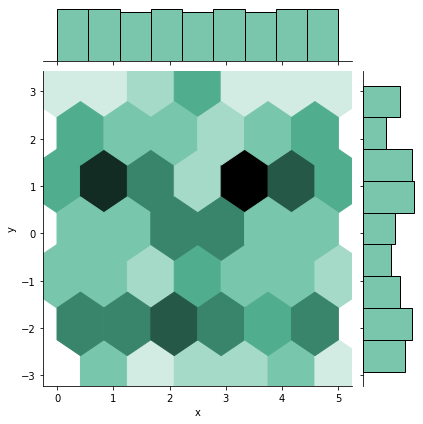

In [56]:
plt.figure()
seaborn.jointplot(df6['x'], df6['y'], kind="hex", color="#4CB391")
plt.xlabel("x")
plt.ylabel("y");